In [4]:
# run and set up imports 

import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image 
import time

print("imports successful")

imports successful


In [5]:
# install ChromaDB

import subprocess 
import sys

print("installing ChromaDB...")
subprocess.check_call([sys.executable, "-m" ,"pip", "install", "-q", "chromadb"])

print("ChromaDB installed")

installing ChromaDB...
ChromaDB installed


In [7]:
# configuration

class Config:
    BASE_PATH = Path('..')
    DATA_PATH = BASE_PATH / 'data'
    EMBEDDINGS_PATH = DATA_PATH / 'embeddings'
    CHROMA_PATH = BASE_PATH / 'chroma_db'

    COLLECTION_NAME = "image_embeddings"
    TOP_K = 5

print("Configuration loaded")
print(f"ChromaDB path: {Config.CHROMA_PATH}")

Configuration loaded
ChromaDB path: ..\chroma_db


In [8]:
# load embeddings and metadata

print("Loading embeddings...")
embeddings = np.load(Config.EMBEDDINGS_PATH / 'image_embeddings.npy')

print("Loading metadata")
with open(Config.EMBEDDINGS_PATH / 'metadata_with_indices.json', 'r') as f:
    metadata = json.load(f)

print(f" Loaded {len(embeddings)} embeddings")
print(f" Loaded metadata for {len(metadata)} images")
print(f"Embedding shape: {embeddings.shape}")

Loading embeddings...
Loading metadata
 Loaded 25 embeddings
 Loaded metadata for 25 images
Embedding shape: (25, 512)


In [16]:
# initialize ChromaDB vector database

import chromadb
from chromadb.config import Settings

print("Initializing ChromaDB...")

# get persistent client
client = chromadb.PersistentClient(path=str(Config.CHROMA_PATH))

# get or create collection 
collection = client.get_or_create_collection(
    name=Config.COLLECTION_NAME,
    metadata={"description": "Visual search engine image embeddings"}
)

print(f" ChromaDB initialized")
print(f"Collection: {Config.COLLECTION_NAME}")
print(f"Current count: {collection.count()}")

Initializing ChromaDB...
 ChromaDB initialized
Collection: image_embeddings
Current count: 0


In [18]:
# add embeddings to vector database 

current_count = collection.count()

if current_count == 0:
    print(f"Adding {len(embeddings)} embeddings to database...")

    # prepare data
    ids = [f"image_{i:06d}" for i in range(len(embeddings))]
    embeddings_list = embeddings.tolist()

    # add to collection
    collection.add(
    embeddings=embeddings_list,
    metadatas=metadata,
    ids=ids
    )

    print(f"  Added {len(embeddings)} embeddings to database")
else:
    print(f" Database already containts {current_count} embeddings")
    print("Skipping insertion (delete chroma_db folder to reset)")

# verify
final_count = collection.count()
print(f"\nFinal database count: {final_count}")

Adding 25 embeddings to database...
  Added 25 embeddings to database

Final database count: 25


In [20]:
# load CLIP model for text encoding 
import torch 
from transformers import CLIPProcessor, CLIPModel

print("Loading CLIP model for text queries...")

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f" CLIP model loaded on {device}")

Loading CLIP model for text queries...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored in: <function tqdm.__del__ at 0x00000289B8D893A0>
Traceback (most recent call last):
  File "C:\Users\00849\visual-search-engine\venv\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\00849\visual-search-engine\venv\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'd

 CLIP model loaded on cpu


In [21]:
# define text query search function

def search_by_text(query, model, processor, collection, device, top_k=5):
    """
    Search for images using a text query
    
    Args:
        query: Text query string
        model: CLIP model
        processor: CLIP processor
        collection: ChromaDB collection
        device: Device (cuda/cpu)
        top_k: Number of results
        
    Returns:
        Search results
    """
    # Encode text query
    inputs = processor(text=[query], return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # Convert to list
    query_embedding = text_features.cpu().numpy().tolist()[0]
    
    # Search in ChromaDB
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )
    
    return results

print("✅ Search function defined")

✅ Search function defined


In [22]:
# test text search 

test_queries = [
    "nature scenery",
    "city buildings",
    "people",
    "food",
    "technology"
]

print("🔍 Testing text-to-image search")
print("=" * 60)

for query in test_queries:
    results = search_by_text(
        query, 
        model, 
        processor, 
        collection, 
        device, 
        top_k=3
    )
    
    print(f"\nQuery: '{query}'")
    print("Top 3 matches:")
    
    for i, (id_, dist, meta) in enumerate(
        zip(results['ids'][0], results['distances'][0], results['metadatas'][0]),
        1
    ):
        # ChromaDB returns distance (lower = more similar)
        similarity = 1 - dist
        category = meta.get('category', 'N/A')
        filename = meta.get('filename', 'N/A')
        
        print(f"  {i}. {filename} (category: {category}, similarity: {similarity:.4f})")

print("\n" + "=" * 60)

🔍 Testing text-to-image search

Query: 'nature scenery'
Top 3 matches:
  1. people_012.jpg (category: people, similarity: -0.7839)
  2. food_003.jpg (category: food, similarity: -0.8303)
  3. city_001.jpg (category: city, similarity: -0.8419)

Query: 'city buildings'
Top 3 matches:
  1. people_012.jpg (category: people, similarity: -0.7662)
  2. classical-musicians.jpg (category: unknown, similarity: -0.8057)
  3. city_011.jpg (category: city, similarity: -0.8498)

Query: 'people'
Top 3 matches:
  1. city_011.jpg (category: city, similarity: -0.8013)
  2. food_003.jpg (category: food, similarity: -0.8289)
  3. people_017.jpg (category: people, similarity: -0.8476)

Query: 'food'
Top 3 matches:
  1. people_012.jpg (category: people, similarity: -0.8288)
  2. food_003.jpg (category: food, similarity: -0.8507)
  3. city_011.jpg (category: city, similarity: -0.8581)

Query: 'technology'
Top 3 matches:
  1. people_012.jpg (category: people, similarity: -0.7735)
  2. city_011.jpg (category: 

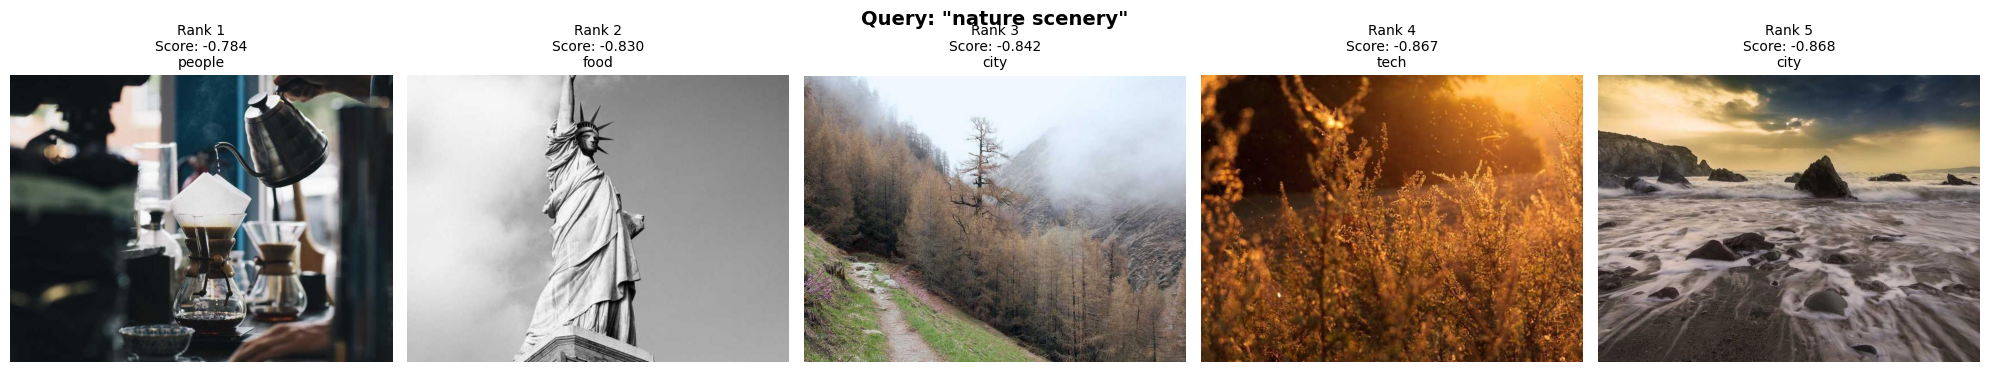

In [23]:
# visualize serach results 

def visualize_search(query, results, n_results=5):
    """Visualize search results"""
    
    fig, axes = plt.subplots(1, n_results, figsize=(20, 4))
    if n_results == 1:
        axes = [axes]
    
    fig.suptitle(f'Query: "{query}"', fontsize=14, fontweight='bold')
    
    for i in range(n_results):
        meta = results['metadatas'][0][i]
        dist = results['distances'][0][i]
        similarity = 1 - dist
        
        # Load image
        img_path = Path(meta['path'])
        if img_path.exists():
            img = Image.open(img_path)
            axes[i].imshow(img)
        else:
            # Placeholder if image not found
            axes[i].text(0.5, 0.5, 'Image\nNot Found', 
                        ha='center', va='center', fontsize=12)
        
        # Set title
        title = f"Rank {i+1}\n"
        title += f"Score: {similarity:.3f}\n"
        title += f"{meta.get('category', 'unknown')}"
        
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize first query
query = test_queries[0]
results = search_by_text(query, model, processor, collection, device, top_k=5)
visualize_search(query, results)


In [24]:
# image to image search 


def search_by_image(image_path, collection, top_k=5):
    """
    Search for similar images using an image
    
    Args:
        image_path: Path to query image
        collection: ChromaDB collection
        top_k: Number of results
        
    Returns:
        Search results
    """
    # Load image and encode
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=[image], return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    # Convert to list
    query_embedding = image_features.cpu().numpy().tolist()[0]
    
    # Search
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k + 1  # +1 because first might be the query itself
    )
    
    return results

# Test with first image
test_image = Path(metadata[0]['path'])

print(f"🖼️  Searching for images similar to: {test_image.name}")

if test_image.exists():
    results = search_by_image(test_image, collection, top_k=6)
    
    print("\nTop similar images:")
    for i, (id_, dist, meta) in enumerate(
        zip(results['ids'][0][1:6], results['distances'][0][1:6], results['metadatas'][0][1:6]),
        1
    ):
        similarity = 1 - dist
        print(f"  {i}. {meta['filename']} (similarity: {similarity:.4f})")
else:
    print(f"Image not found: {test_image}")

🖼️  Searching for images similar to: b80d45-20120627-flute-concert.jpg

Top similar images:
  1. people_007.jpg (similarity: -0.8859)
  2. Classical_Music_thumbnail.jpg (similarity: -0.9097)
  3. nature_000.jpg (similarity: -0.9119)
  4. people_002.jpg (similarity: -0.9191)
  5. nature_015.jpg (similarity: -0.9399)


In [26]:
# benchmark search speed 

print("⚡ Benchmarking search performance...")

n_iterations = 100
times = []

# Warm up
_ = search_by_text("test", model, processor, collection, device, top_k=5)

# Benchmark
for i in range(n_iterations):
    query = np.random.choice(test_queries)
    
    start_time = time.time()
    _ = search_by_text(query, model, processor, collection, device, top_k=5)
    end_time = time.time()
    
    times.append(end_time - start_time)

print(f"\nSearch benchmark ({n_iterations} iterations):")
print(f"  Average time: {np.mean(times)*1000:.2f} ms")
print(f"  Median time: {np.median(times)*1000:.2f} ms")
print(f"  Min time: {np.min(times)*1000:.2f} ms")
print(f"  Max time: {np.max(times)*1000:.2f} ms")
print(f"  Queries per second: {1/np.mean(times):.2f}")

⚡ Benchmarking search performance...

Search benchmark (100 iterations):
  Average time: 37.37 ms
  Median time: 34.34 ms
  Min time: 23.80 ms
  Max time: 75.51 ms
  Queries per second: 26.76


In [27]:
# summary 

print("\n" + "=" * 60)
print("🎉 RAG RETRIEVAL SYSTEM COMPLETE!")
print("=" * 60)

print("\n✅ What we accomplished:")
print(f"  • Built vector database with ChromaDB")
print(f"  • Indexed {collection.count()} image embeddings")
print(f"  • Implemented text-to-image search")
print(f"  • Implemented image-to-image search")
print(f"  • Average search time: {np.mean(times)*1000:.2f} ms")

print("\n📁 Database location:")
print(f"  {Config.CHROMA_PATH}")

print("\n⏭️  Next Steps:")
print("  1. ✅ Data exploration (Notebook 01)")
print("  2. ✅ Embedding generation (Notebook 02)")
print("  3. ✅ RAG retrieval (Notebook 03)")
print("  4. ⏭️  Optional: Notebook 04 (PyTorch vs TensorFlow)")
print("  5. ⏭️  Build REST API")
print("  6. ⏭️  Dockerize application")

print("\n" + "=" * 60)


🎉 RAG RETRIEVAL SYSTEM COMPLETE!

✅ What we accomplished:
  • Built vector database with ChromaDB
  • Indexed 25 image embeddings
  • Implemented text-to-image search
  • Implemented image-to-image search
  • Average search time: 37.37 ms

📁 Database location:
  ..\chroma_db

⏭️  Next Steps:
  1. ✅ Data exploration (Notebook 01)
  2. ✅ Embedding generation (Notebook 02)
  3. ✅ RAG retrieval (Notebook 03)
  4. ⏭️  Optional: Notebook 04 (PyTorch vs TensorFlow)
  5. ⏭️  Build REST API
  6. ⏭️  Dockerize application

